# Technical Analysis - Moving Averages, RSI, and MACD

This notebook calculates technical indicators for all stocks using pure DuckDB SQL:
- **Moving Averages**: SMA(20, 60, 120, 240)
- **RSI**: Relative Strength Index (14-period)
- **MACD**: Moving Average Convergence Divergence (12, 26, 9)

Data sources: `daily_charts` and `weekly_charts` tables

## Setup

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import platform
import warnings
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Korean font configuration for cross-platform support
def setup_korean_font():
    """Setup Korean font for matplotlib based on OS"""
    system = platform.system()
    
    if system == 'Darwin':  # macOS
        font_candidates = ['AppleGothic', 'Apple SD Gothic Neo', 'NanumGothic']
    elif system == 'Windows':
        font_candidates = ['Malgun Gothic', 'NanumGothic']
    else:  # Linux
        font_candidates = ['NanumGothic', 'DejaVu Sans']
    
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    for font in font_candidates:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            print(f"Using font: {font}")
            break
    else:
        print(f"No Korean font found. Available fonts: {available_fonts[:5]}...")
    
    plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

setup_korean_font()

Using font: AppleGothic


In [3]:
# Connect to DuckDB
db_path = Path.cwd().parent / "data" / "data.duckdb"
print(f"Connecting to database: {db_path}")
print(f"Database exists: {db_path.exists()}")

conn = duckdb.connect(str(db_path), read_only=True)
print("✓ Connected to DuckDB")

Connecting to database: /Volumes/kgcrom-2tb/kgcrom/workspace/cluefin/data/data.duckdb
Database exists: True
✓ Connected to DuckDB


In [4]:
# Get database overview
stats = conn.execute("""
    SELECT 
        'daily_charts' as table_name,
        COUNT(*) as record_count,
        COUNT(DISTINCT stock_code) as stock_count,
        MIN(date) as min_date,
        MAX(date) as max_date
    FROM daily_charts
    UNION ALL
    SELECT 
        'weekly_charts' as table_name,
        COUNT(*) as record_count,
        COUNT(DISTINCT stock_code) as stock_count,
        MIN(date) as min_date,
        MAX(date) as max_date
    FROM weekly_charts
    UNION ALL
    SELECT 
        'stock_metadata' as table_name,
        COUNT(*) as record_count,
        NULL as stock_count,
        NULL as min_date,
        NULL as max_date
    FROM stock_metadata
""").df()

print("\n=== Database Overview ===")
print(stats.to_string(index=False))


=== Database Overview ===
    table_name  record_count  stock_count   min_date   max_date
  daily_charts       1798617         2606 2022-10-27 2025-10-31
 weekly_charts        382334         2605 2022-10-27 2025-10-27
stock_metadata          2606         <NA>        NaT        NaT


## 1. Simple Moving Averages (SMA)

Calculate SMA for periods: 20, 60, 120, 240 days using DuckDB window functions

In [5]:
# Test SMA calculation for Samsung (005930) - Daily charts
sma_query = """
SELECT 
    stock_code,
    date,
    close,
    AVG(close) OVER (
        PARTITION BY stock_code 
        ORDER BY date 
        ROWS BETWEEN 19 PRECEDING AND CURRENT ROW
    ) as sma_20,
    AVG(close) OVER (
        PARTITION BY stock_code 
        ORDER BY date 
        ROWS BETWEEN 59 PRECEDING AND CURRENT ROW
    ) as sma_60,
    AVG(close) OVER (
        PARTITION BY stock_code 
        ORDER BY date 
        ROWS BETWEEN 119 PRECEDING AND CURRENT ROW
    ) as sma_120,
    AVG(close) OVER (
        PARTITION BY stock_code 
        ORDER BY date 
        ROWS BETWEEN 239 PRECEDING AND CURRENT ROW
    ) as sma_240
FROM daily_charts
WHERE stock_code = '005930'
ORDER BY date DESC
LIMIT 10
"""

df_sma_test = conn.execute(sma_query).df()
print("\n=== SMA Test Results (Samsung 005930 - Latest 10 days) ===")
print(df_sma_test.to_string(index=False))


=== SMA Test Results (Samsung 005930 - Latest 10 days) ===
stock_code       date  close  sma_20       sma_60      sma_120      sma_240
    005930 2025-10-31 107500 95805.0 80865.000000 70640.000000 63034.166667
    005930 2025-10-30 104100 94595.0 80263.333333 70196.666667 62830.833333
    005930 2025-10-29 100500 93695.0 79738.333333 69791.666667 62640.000000
    005930 2025-10-28  99500 92940.0 79240.000000 69419.166667 62467.916667
    005930 2025-10-27 102000 92200.0 78755.000000 69055.000000 62299.583333
    005930 2025-10-24  98800 91275.0 78153.333333 68669.166667 62122.916667
    005930 2025-10-23  96500 90320.0 77606.666667 68310.000000 61953.333333
    005930 2025-10-22  98600 89520.0 77105.000000 67970.000000 61784.166667
    005930 2025-10-21  97500 88500.0 76561.666667 67606.666667 61609.166667
    005930 2025-10-20  98100 87595.0 76066.666667 67255.833333 61449.166667


## 2. RSI (Relative Strength Index)

Calculate 14-period RSI using pure SQL:
1. Calculate price changes (gains/losses)
2. Compute average gains and losses (14-period)
3. Calculate RS = avg_gain / avg_loss
4. RSI = 100 - (100 / (1 + RS))

In [6]:
# RSI Calculation in pure SQL
rsi_query = """
WITH price_changes AS (
    SELECT 
        stock_code,
        date,
        close,
        close - LAG(close, 1) OVER (PARTITION BY stock_code ORDER BY date) as price_change
    FROM daily_charts
    WHERE stock_code = '005930'
),
gains_losses AS (
    SELECT 
        stock_code,
        date,
        close,
        price_change,
        CASE WHEN price_change > 0 THEN price_change ELSE 0 END as gain,
        CASE WHEN price_change < 0 THEN ABS(price_change) ELSE 0 END as loss
    FROM price_changes
),
avg_gains_losses AS (
    SELECT 
        stock_code,
        date,
        close,
        AVG(gain) OVER (
            PARTITION BY stock_code 
            ORDER BY date 
            ROWS BETWEEN 13 PRECEDING AND CURRENT ROW
        ) as avg_gain,
        AVG(loss) OVER (
            PARTITION BY stock_code 
            ORDER BY date 
            ROWS BETWEEN 13 PRECEDING AND CURRENT ROW
        ) as avg_loss
    FROM gains_losses
)
SELECT 
    stock_code,
    date,
    close,
    avg_gain,
    avg_loss,
    CASE 
        WHEN avg_loss = 0 THEN 100
        ELSE 100 - (100 / (1 + (avg_gain / avg_loss)))
    END as rsi_14
FROM avg_gains_losses
ORDER BY date DESC
LIMIT 10
"""

df_rsi_test = conn.execute(rsi_query).df()
print("\n=== RSI Test Results (Samsung 005930 - Latest 10 days) ===")
print(df_rsi_test.to_string(index=False))


=== RSI Test Results (Samsung 005930 - Latest 10 days) ===
stock_code       date  close    avg_gain   avg_loss    rsi_14
    005930 2025-10-31 107500 1507.142857 492.857143 75.357143
    005930 2025-10-30 104100 1264.285714 571.428571 68.871595
    005930 2025-10-29 100500 1392.857143 571.428571 70.909091
    005930 2025-10-28  99500 1535.714286 571.428571 72.881356
    005930 2025-10-27 102000 1685.714286 392.857143 81.099656
    005930 2025-10-24  98800 1457.142857 414.285714 77.862595
    005930 2025-10-23  96500 1357.142857 414.285714 76.612903
    005930 2025-10-22  98600 1357.142857 464.285714 74.509804
    005930 2025-10-21  97500 1328.571429 464.285714 74.103586
    005930 2025-10-20  98100 1378.571429 421.428571 76.587302


## 3. MACD (Moving Average Convergence Divergence)

Calculate MACD using exponential moving averages:
- EMA(12) and EMA(26) for MACD line
- EMA(9) of MACD for signal line
- Histogram = MACD - Signal

**Note**: EMA in SQL is complex. We'll use a recursive approach with exponential smoothing.

In [7]:
# MACD Calculation using EMA approximation
# Fixed: Calculate row numbers separately to avoid nested window functions
macd_query = """
WITH price_data AS (
    SELECT
        stock_code,
        date,
        close,
        ROW_NUMBER() OVER (PARTITION BY stock_code ORDER BY date) as row_num_asc,
        ROW_NUMBER() OVER (PARTITION BY stock_code ORDER BY date DESC) as row_num_desc
    FROM daily_charts
    WHERE stock_code = '005930'
),
-- Calculate EMA-like weighted averages using pre-calculated row numbers
ema_calcs AS (
    SELECT
        stock_code,
        date,
        close,
        row_num_asc,
        row_num_desc,
        -- EMA(12) approximation: smoothing factor = 2/(12+1) = 0.1538
        AVG(close * EXP(-0.1538 * (row_num_desc - 1)))
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.1538 * (row_num_desc - 1)))
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW), 0)
        as ema_12,
        -- EMA(26) approximation: smoothing factor = 2/(26+1) = 0.0741
        AVG(close * EXP(-0.0741 * (row_num_desc - 1)))
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.0741 * (row_num_desc - 1)))
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 25 PRECEDING AND CURRENT ROW), 0)
        as ema_26
    FROM price_data
),
macd_line AS (
    SELECT
        stock_code,
        date,
        close,
        row_num_desc,
        ema_12,
        ema_26,
        ema_12 - ema_26 as macd
    FROM ema_calcs
),
-- Calculate signal line with pre-calculated row numbers
macd_with_signal AS (
    SELECT
        stock_code,
        date,
        close,
        ema_12,
        ema_26,
        macd,
        -- Signal line: EMA(9) of MACD, smoothing factor = 2/(9+1) = 0.2
        AVG(macd * EXP(-0.2 * (row_num_desc - 1)))
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 8 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.2 * (row_num_desc - 1)))
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 8 PRECEDING AND CURRENT ROW), 0)
        as macd_signal
    FROM macd_line
)
SELECT
    stock_code,
    date,
    close,
    ROUND(ema_12, 2) as ema_12,
    ROUND(ema_26, 2) as ema_26,
    ROUND(macd, 2) as macd,
    ROUND(macd_signal, 2) as macd_signal,
    ROUND(macd - macd_signal, 2) as macd_histogram
FROM macd_with_signal
ORDER BY date DESC
LIMIT 10
"""

df_macd_test = conn.execute(macd_query).df()
print("\n=== MACD Test Results (Samsung 005930 - Latest 10 days) ===")
print(df_macd_test.to_string(index=False))


=== MACD Test Results (Samsung 005930 - Latest 10 days) ===
stock_code       date  close    ema_12   ema_26    macd  macd_signal  macd_histogram
    005930 2025-10-31 107500 101294.02 96763.50 4530.52      4542.90          -12.38
    005930 2025-10-30 104100  99872.46 95583.69 4288.77      4575.04         -286.27
    005930 2025-10-29 100500  98779.83 94589.07 4190.76      4679.06         -488.31
    005930 2025-10-28  99500  98269.33 93857.78 4411.55      4828.16         -416.61
    005930 2025-10-27 102000  97905.69 93122.24 4783.45      4942.69         -159.24
    005930 2025-10-24  98800  96819.62 92090.65 4728.97      4980.01         -251.04
    005930 2025-10-23  96500  96091.24 91241.57 4849.68      5042.85         -193.17
    005930 2025-10-22  98600  95630.39 90523.75 5106.65      5079.19           27.46
    005930 2025-10-21  97500  94687.66 89547.24 5140.42      5033.05          107.37
    005930 2025-10-20  98100  93777.30 88576.30 5201.00      4963.14          237.87


## 4. Combined Indicators - Daily Charts

Calculate all technical indicators for all stocks in daily_charts

In [8]:
# Combined query for all indicators - Daily charts
# Fixed: Pre-calculate row numbers to avoid nested window functions
daily_indicators_query = """
WITH price_data AS (
    SELECT 
        dc.stock_code,
        dc.date,
        dc.open,
        dc.high,
        dc.low,
        dc.close,
        dc.volume,
        ROW_NUMBER() OVER (PARTITION BY dc.stock_code ORDER BY dc.date) as row_num_asc,
        ROW_NUMBER() OVER (PARTITION BY dc.stock_code ORDER BY dc.date DESC) as row_num_desc
    FROM daily_charts dc
    INNER JOIN stock_metadata sm ON dc.stock_code = sm.stock_code
),
-- Moving Averages
with_sma AS (
    SELECT 
        *,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) as sma_20,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) as sma_60,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 119 PRECEDING AND CURRENT ROW) as sma_120,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 239 PRECEDING AND CURRENT ROW) as sma_240
    FROM price_data
),
-- RSI Calculation
with_price_changes AS (
    SELECT 
        *,
        close - LAG(close, 1) OVER (PARTITION BY stock_code ORDER BY date) as price_change
    FROM with_sma
),
with_gains_losses AS (
    SELECT 
        *,
        CASE WHEN price_change > 0 THEN price_change ELSE 0 END as gain,
        CASE WHEN price_change < 0 THEN ABS(price_change) ELSE 0 END as loss
    FROM with_price_changes
),
with_rsi AS (
    SELECT 
        *,
        AVG(gain) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) as avg_gain,
        AVG(loss) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) as avg_loss
    FROM with_gains_losses
),
with_rsi_final AS (
    SELECT 
        stock_code,
        date,
        open,
        high,
        low,
        close,
        volume,
        row_num_desc,
        sma_20,
        sma_60,
        sma_120,
        sma_240,
        CASE 
            WHEN avg_loss = 0 THEN 100
            ELSE 100 - (100 / (1 + (avg_gain / avg_loss)))
        END as rsi_14
    FROM with_rsi
),
-- MACD Calculation with pre-calculated row numbers
with_ema AS (
    SELECT 
        *,
        AVG(close * EXP(-0.1538 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.1538 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW), 0) 
        as ema_12,
        AVG(close * EXP(-0.0741 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.0741 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 25 PRECEDING AND CURRENT ROW), 0) 
        as ema_26
    FROM with_rsi_final
),
with_macd AS (
    SELECT 
        *,
        ema_12 - ema_26 as macd
    FROM with_ema
),
with_macd_signal AS (
    SELECT 
        *,
        AVG(macd * EXP(-0.2 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 8 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.2 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 8 PRECEDING AND CURRENT ROW), 0) 
        as macd_signal
    FROM with_macd
)
SELECT 
    stock_code,
    date,
    open,
    high,
    low,
    close,
    volume,
    ROUND(sma_20, 2) as sma_20,
    ROUND(sma_60, 2) as sma_60,
    ROUND(sma_120, 2) as sma_120,
    ROUND(sma_240, 2) as sma_240,
    ROUND(rsi_14, 2) as rsi_14,
    ROUND(ema_12, 2) as ema_12,
    ROUND(ema_26, 2) as ema_26,
    ROUND(macd, 2) as macd,
    ROUND(macd_signal, 2) as macd_signal,
    ROUND(macd - macd_signal, 2) as macd_histogram
FROM with_macd_signal
WHERE stock_code = '005930'  -- Test with Samsung first
ORDER BY date DESC
LIMIT 20
"""

print("\n=== Calculating Daily Indicators for Samsung (005930) ===")
df_daily_indicators = conn.execute(daily_indicators_query).df()
print(f"\nTotal records: {len(df_daily_indicators)}")
print("\nLatest 5 records:")
print(df_daily_indicators.head().to_string(index=False))


=== Calculating Daily Indicators for Samsung (005930) ===

Total records: 20

Latest 5 records:
stock_code       date   open   high    low  close   volume  sma_20   sma_60  sma_120  sma_240  rsi_14    ema_12   ema_26    macd  macd_signal  macd_histogram
    005930 2025-10-31 105000 108600 103300 107500 54824564 95805.0 80865.00 70640.00 63034.17   75.36 101294.02 96763.50 4530.52      4542.90          -12.38
    005930 2025-10-30 102400 105800 102000 104100 34570017 94595.0 80263.33 70196.67 62830.83   68.87  99872.46 95583.69 4288.77      4575.04         -286.27
    005930 2025-10-29 100200 101000  99100 100500 20899788 93695.0 79738.33 69791.67 62640.00   70.91  98779.83 94589.07 4190.76      4679.06         -488.31
    005930 2025-10-28 100900 101000  99100  99500 20002282 92940.0 79240.00 69419.17 62467.92   72.88  98269.33 93857.78 4411.55      4828.16         -416.61
    005930 2025-10-27 101300 102000 100600 102000 22169970 92200.0 78755.00 69055.00 62299.58   81.10  97905.69 9

## 5. Combined Indicators - Weekly Charts

Calculate all technical indicators for all stocks in weekly_charts

In [9]:
# Combined query for all indicators - Weekly charts
# Fixed: Pre-calculate row numbers to avoid nested window functions
weekly_indicators_query = """
WITH price_data AS (
    SELECT 
        wc.stock_code,
        wc.date,
        wc.open,
        wc.high,
        wc.low,
        wc.close,
        wc.volume,
        ROW_NUMBER() OVER (PARTITION BY wc.stock_code ORDER BY wc.date) as row_num_asc,
        ROW_NUMBER() OVER (PARTITION BY wc.stock_code ORDER BY wc.date DESC) as row_num_desc
    FROM weekly_charts wc
    INNER JOIN stock_metadata sm ON wc.stock_code = sm.stock_code
),
-- Moving Averages
with_sma AS (
    SELECT 
        *,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) as sma_20,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) as sma_60,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 119 PRECEDING AND CURRENT ROW) as sma_120,
        AVG(close) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 239 PRECEDING AND CURRENT ROW) as sma_240
    FROM price_data
),
-- RSI Calculation
with_price_changes AS (
    SELECT 
        *,
        close - LAG(close, 1) OVER (PARTITION BY stock_code ORDER BY date) as price_change
    FROM with_sma
),
with_gains_losses AS (
    SELECT 
        *,
        CASE WHEN price_change > 0 THEN price_change ELSE 0 END as gain,
        CASE WHEN price_change < 0 THEN ABS(price_change) ELSE 0 END as loss
    FROM with_price_changes
),
with_rsi AS (
    SELECT 
        *,
        AVG(gain) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) as avg_gain,
        AVG(loss) OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) as avg_loss
    FROM with_gains_losses
),
with_rsi_final AS (
    SELECT 
        stock_code,
        date,
        open,
        high,
        low,
        close,
        volume,
        row_num_desc,
        sma_20,
        sma_60,
        sma_120,
        sma_240,
        CASE 
            WHEN avg_loss = 0 THEN 100
            ELSE 100 - (100 / (1 + (avg_gain / avg_loss)))
        END as rsi_14
    FROM with_rsi
),
-- MACD Calculation with pre-calculated row numbers
with_ema AS (
    SELECT 
        *,
        AVG(close * EXP(-0.1538 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.1538 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 11 PRECEDING AND CURRENT ROW), 0) 
        as ema_12,
        AVG(close * EXP(-0.0741 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.0741 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 25 PRECEDING AND CURRENT ROW), 0) 
        as ema_26
    FROM with_rsi_final
),
with_macd AS (
    SELECT 
        *,
        ema_12 - ema_26 as macd
    FROM with_ema
),
with_macd_signal AS (
    SELECT 
        *,
        AVG(macd * EXP(-0.2 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 8 PRECEDING AND CURRENT ROW) /
        NULLIF(AVG(EXP(-0.2 * (row_num_desc - 1))) 
            OVER (PARTITION BY stock_code ORDER BY date ROWS BETWEEN 8 PRECEDING AND CURRENT ROW), 0) 
        as macd_signal
    FROM with_macd
)
SELECT 
    stock_code,
    date,
    open,
    high,
    low,
    close,
    volume,
    ROUND(sma_20, 2) as sma_20,
    ROUND(sma_60, 2) as sma_60,
    ROUND(sma_120, 2) as sma_120,
    ROUND(sma_240, 2) as sma_240,
    ROUND(rsi_14, 2) as rsi_14,
    ROUND(ema_12, 2) as ema_12,
    ROUND(ema_26, 2) as ema_26,
    ROUND(macd, 2) as macd,
    ROUND(macd_signal, 2) as macd_signal,
    ROUND(macd - macd_signal, 2) as macd_histogram
FROM with_macd_signal
WHERE stock_code = '005930'  -- Test with Samsung first
ORDER BY date DESC
LIMIT 20
"""

print("\n=== Calculating Weekly Indicators for Samsung (005930) ===")
df_weekly_indicators = conn.execute(weekly_indicators_query).df()
print(f"\nTotal records: {len(df_weekly_indicators)}")
print("\nLatest 5 records:")
print(df_weekly_indicators.head().to_string(index=False))


=== Calculating Weekly Indicators for Samsung (005930) ===

Total records: 20

Latest 5 records:
stock_code       date   open   high   low  close    volume  sma_20   sma_60  sma_120  sma_240  rsi_14   ema_12   ema_26     macd  macd_signal  macd_histogram
    005930 2025-10-27 101300 102000 99100 100500  63072040 76055.0 63030.00 68824.17 67738.85   94.13 89230.32 79039.48 10190.84      8109.47         2081.37
    005930 2025-10-20  97900  99900 95500  98800  93621703 73945.0 62503.33 68598.33 67528.85   90.96 86461.74 76783.10  9678.64      7393.04         2285.60
    005930 2025-10-13  91300  99100 90200  97900 131350523 71960.0 62095.00 68357.50 67327.10   91.73 83478.08 74524.57  8953.51      6656.25         2297.26
    005930 2025-10-10  94000  94500 92700  94400  35269748 69875.0 61758.33 68143.33 67128.57   89.37 80082.51 72168.10  7914.41      5934.80         1979.60
    005930 2025-09-29  83300  90300 83200  89000 101310544 67865.0 61521.67 67953.33 66950.33   88.52 76850.85 6

## 6. Visualizations - Samsung (005930)

Create charts to verify the technical indicator calculations

In [10]:
# Get more data for visualization (last 240 days)
viz_query = daily_indicators_query.replace("LIMIT 20", "LIMIT 240")
df_viz = conn.execute(viz_query).df().sort_values('date')

print(f"\nVisualization data: {len(df_viz)} records")
print(f"Date range: {df_viz['date'].min()} to {df_viz['date'].max()}")


Visualization data: 240 records
Date range: 2024-11-05 00:00:00 to 2025-10-31 00:00:00


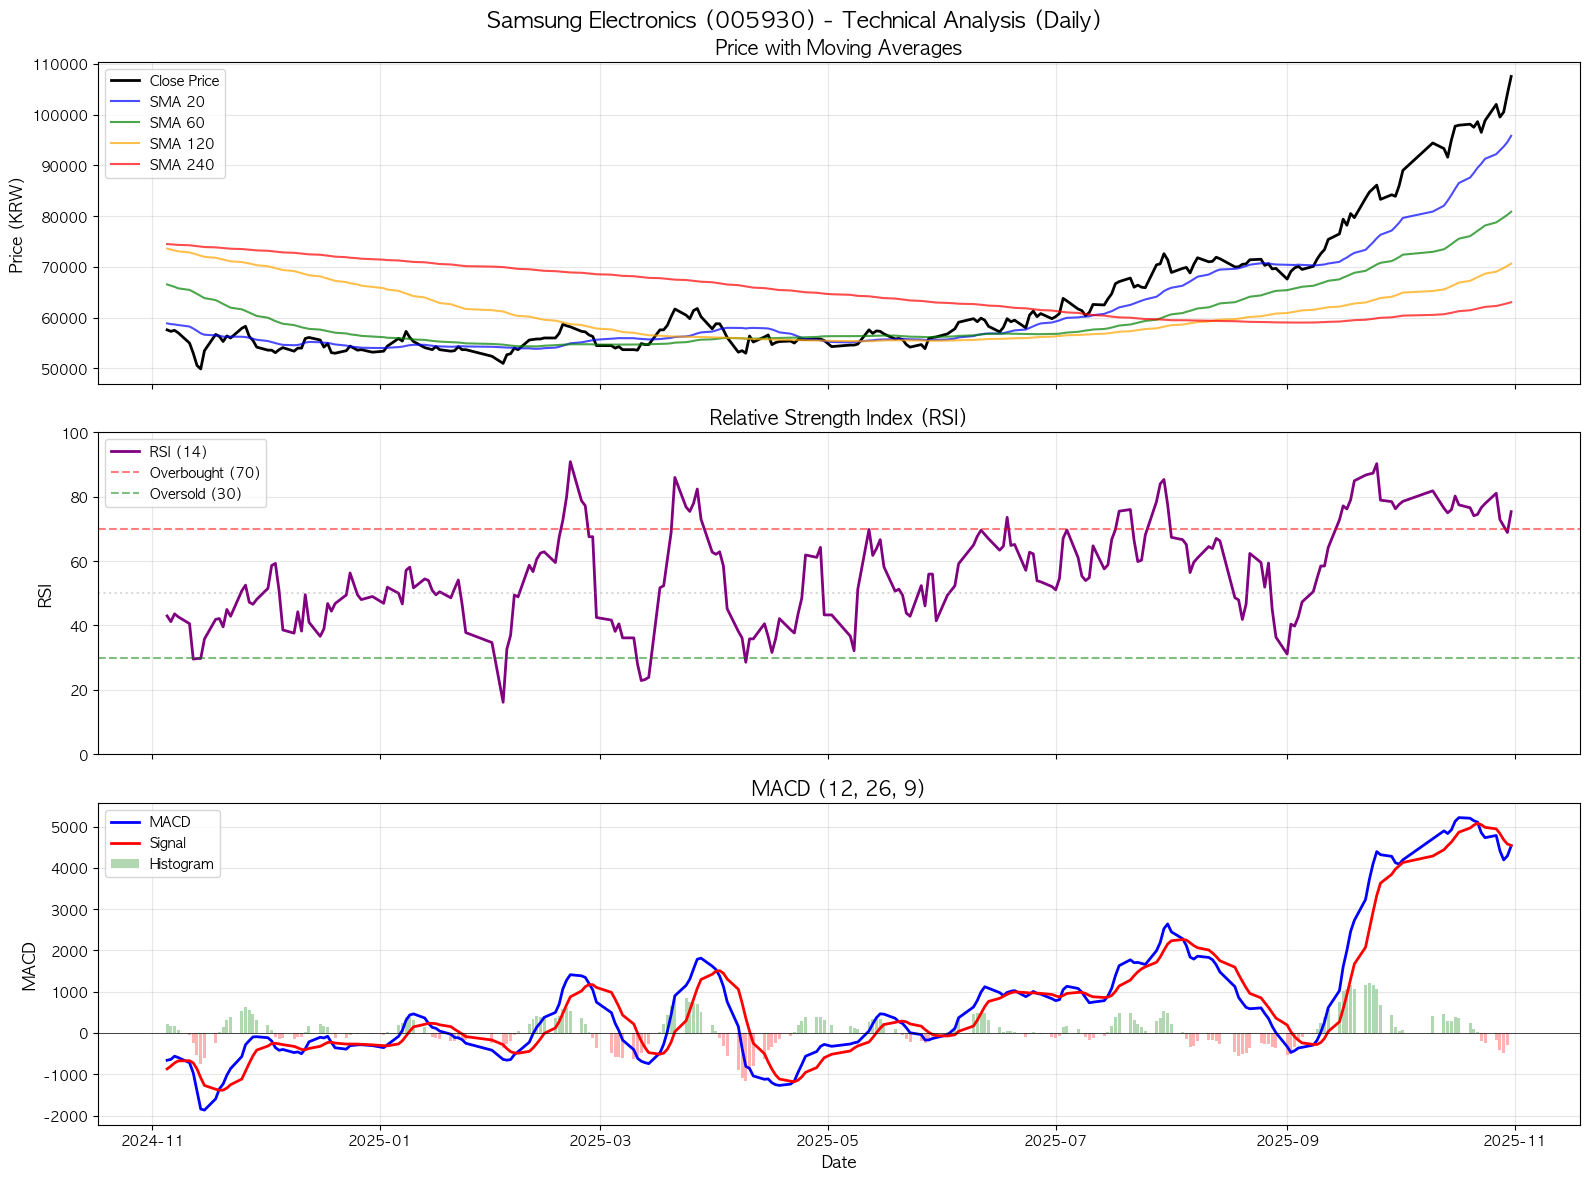


✓ Chart displayed successfully


In [11]:
# Create comprehensive technical analysis chart
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Samsung Electronics (005930) - Technical Analysis (Daily)', fontsize=16, fontweight='bold')

# Plot 1: Price and Moving Averages
ax1 = axes[0]
ax1.plot(df_viz['date'], df_viz['close'], label='Close Price', color='black', linewidth=2)
ax1.plot(df_viz['date'], df_viz['sma_20'], label='SMA 20', color='blue', alpha=0.7)
ax1.plot(df_viz['date'], df_viz['sma_60'], label='SMA 60', color='green', alpha=0.7)
ax1.plot(df_viz['date'], df_viz['sma_120'], label='SMA 120', color='orange', alpha=0.7)
ax1.plot(df_viz['date'], df_viz['sma_240'], label='SMA 240', color='red', alpha=0.7)
ax1.set_ylabel('Price (KRW)', fontsize=12)
ax1.set_title('Price with Moving Averages', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: RSI
ax2 = axes[1]
ax2.plot(df_viz['date'], df_viz['rsi_14'], label='RSI (14)', color='purple', linewidth=2)
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.3)
ax2.set_ylabel('RSI', fontsize=12)
ax2.set_title('Relative Strength Index (RSI)', fontsize=14)
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: MACD
ax3 = axes[2]
ax3.plot(df_viz['date'], df_viz['macd'], label='MACD', color='blue', linewidth=2)
ax3.plot(df_viz['date'], df_viz['macd_signal'], label='Signal', color='red', linewidth=2)
ax3.bar(df_viz['date'], df_viz['macd_histogram'], label='Histogram', 
        color=['green' if x >= 0 else 'red' for x in df_viz['macd_histogram']], 
        alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('MACD', fontsize=12)
ax3.set_title('MACD (12, 26, 9)', fontsize=14)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Chart displayed successfully")

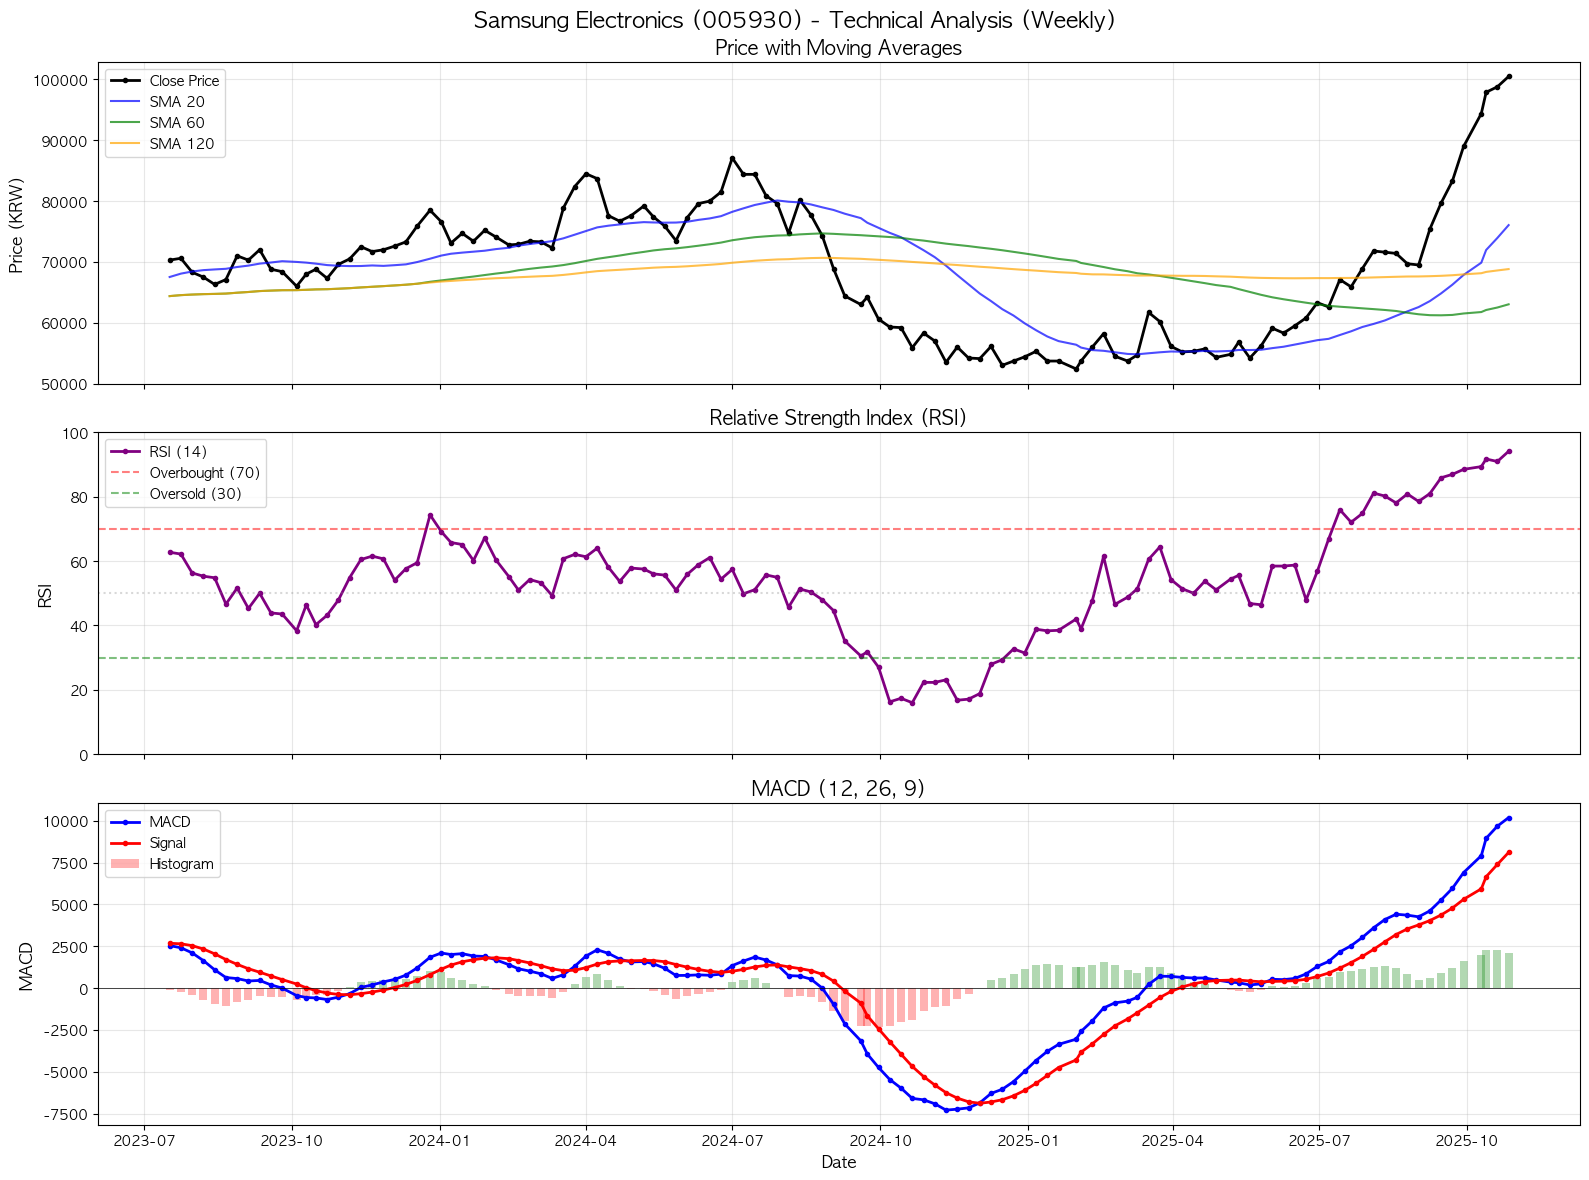


✓ Weekly chart displayed successfully


In [12]:
# Create weekly chart visualization
viz_query_weekly = weekly_indicators_query.replace("LIMIT 20", "LIMIT 120")
df_viz_weekly = conn.execute(viz_query_weekly).df().sort_values('date')

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Samsung Electronics (005930) - Technical Analysis (Weekly)', fontsize=16, fontweight='bold')

# Plot 1: Price and Moving Averages
ax1 = axes[0]
ax1.plot(df_viz_weekly['date'], df_viz_weekly['close'], label='Close Price', color='black', linewidth=2, marker='o', markersize=3)
ax1.plot(df_viz_weekly['date'], df_viz_weekly['sma_20'], label='SMA 20', color='blue', alpha=0.7)
ax1.plot(df_viz_weekly['date'], df_viz_weekly['sma_60'], label='SMA 60', color='green', alpha=0.7)
ax1.plot(df_viz_weekly['date'], df_viz_weekly['sma_120'], label='SMA 120', color='orange', alpha=0.7)
ax1.set_ylabel('Price (KRW)', fontsize=12)
ax1.set_title('Price with Moving Averages', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: RSI
ax2 = axes[1]
ax2.plot(df_viz_weekly['date'], df_viz_weekly['rsi_14'], label='RSI (14)', color='purple', linewidth=2, marker='o', markersize=3)
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.3)
ax2.set_ylabel('RSI', fontsize=12)
ax2.set_title('Relative Strength Index (RSI)', fontsize=14)
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: MACD
ax3 = axes[2]
ax3.plot(df_viz_weekly['date'], df_viz_weekly['macd'], label='MACD', color='blue', linewidth=2, marker='o', markersize=3)
ax3.plot(df_viz_weekly['date'], df_viz_weekly['macd_signal'], label='Signal', color='red', linewidth=2, marker='o', markersize=3)
ax3.bar(df_viz_weekly['date'], df_viz_weekly['macd_histogram'], label='Histogram', 
        color=['green' if x >= 0 else 'red' for x in df_viz_weekly['macd_histogram']], 
        alpha=0.3, width=5)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('MACD', fontsize=12)
ax3.set_title('MACD (12, 26, 9)', fontsize=14)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Weekly chart displayed successfully")

## 7. Calculate for All Stocks

Now that we've verified the calculations work correctly, let's run them for all stocks

In [13]:
# Get stock count
stock_count = conn.execute("""
    SELECT COUNT(DISTINCT stock_code) as count
    FROM stock_metadata
""").df()['count'][0]

print(f"\nTotal stocks in database: {stock_count}")
print("\nNote: Calculating indicators for all stocks may take several minutes...")
print("For production use, consider:")
print("  1. Saving results to new DuckDB tables (stock_indicators_daily/weekly)")
print("  2. Processing in batches")
print("  3. Using parallel processing for large datasets")


Total stocks in database: 2606

Note: Calculating indicators for all stocks may take several minutes...
For production use, consider:
  1. Saving results to new DuckDB tables (stock_indicators_daily/weekly)
  2. Processing in batches
  3. Using parallel processing for large datasets


In [14]:
# Sample calculation for top 10 stocks by latest close price (daily)
top_stocks_query = """
WITH latest_prices AS (
    SELECT 
        stock_code,
        close,
        ROW_NUMBER() OVER (PARTITION BY stock_code ORDER BY date DESC) as rn
    FROM daily_charts
)
SELECT stock_code, close
FROM latest_prices
WHERE rn = 1
ORDER BY close DESC
LIMIT 10
"""

top_stocks = conn.execute(top_stocks_query).df()
print("\n=== Top 10 Stocks by Price ===")
print(top_stocks.to_string(index=False))


=== Top 10 Stocks by Price ===
stock_code   close
    298040 2135000
    003230 1348000
    207940 1221000
    010130 1033000
    012450  979000
    000150  949000
    267260  870000
    003240  802000
    329180  600000
    000660  559000


In [15]:
# Calculate indicators for top 10 stocks - Daily
stock_codes = ','.join([f"'{code}'" for code in top_stocks['stock_code'].tolist()])
all_stocks_query = daily_indicators_query.replace(
    "WHERE stock_code = '005930'",
    f"WHERE stock_code IN ({stock_codes})"
).replace("LIMIT 20", "")

print("\n=== Calculating Daily Indicators for Top 10 Stocks ===")
print("This may take a moment...\n")

df_all_daily = conn.execute(all_stocks_query).df()

print(f"✓ Calculated indicators for {df_all_daily['stock_code'].nunique()} stocks")
print(f"✓ Total records: {len(df_all_daily):,}")
print(f"✓ Date range: {df_all_daily['date'].min()} to {df_all_daily['date'].max()}")

# Show summary statistics
print("\n=== Summary Statistics (Latest Date) ===")
latest_date = df_all_daily['date'].max()
latest_data = df_all_daily[df_all_daily['date'] == latest_date]
print(f"\nData for {latest_date}:")
print(latest_data[['stock_code', 'close', 'sma_20', 'sma_60', 'rsi_14', 'macd', 'macd_signal']].to_string(index=False))


=== Calculating Daily Indicators for Top 10 Stocks ===
This may take a moment...

✓ Calculated indicators for 10 stocks
✓ Total records: 7,360
✓ Date range: 2022-10-27 00:00:00 to 2025-10-31 00:00:00

=== Summary Statistics (Latest Date) ===

Data for 2025-10-31 00:00:00:
stock_code   close    sma_20     sma_60  rsi_14      macd  macd_signal
    298040 2135000 1679600.0 1407583.33   92.06 186153.59    151322.83
    003230 1348000 1374950.0 1456083.33   40.98 -55759.61    -65620.33
    012450  979000 1006450.0  962583.33   48.18  -8884.03    -12925.66
    207940 1221000 1117350.0 1056650.00   86.28  58362.66     52710.14
    010130 1033000 1123150.0  949016.67   41.64  10956.94     50279.90
    267260  870000  710600.0  584491.67   82.69  71836.75     57090.88
    000150  949000  718600.0  624600.00   89.11 107569.09     82480.67
    329180  600000  547425.0  508983.33   71.28  28744.17     24258.01
    000660  559000  461125.0  346225.00   83.33  51187.96     46810.40
    003240  8020

## 8. Summary and Next Steps

### What We've Built

✓ **Pure SQL Implementation** - All calculations use DuckDB SQL
- Moving Averages (SMA 20, 60, 120, 240) using window functions
- RSI(14) using gain/loss calculations with CTEs
- MACD(12, 26, 9) using exponential weighted averages

✓ **Both Timeframes** - Daily and weekly charts support

✓ **Visualizations** - Sample charts for Samsung to verify calculations

### Performance Considerations

The current implementation calculates indicators on-demand. For production use:

1. **Save to DuckDB tables**: Create `stock_indicators_daily` and `stock_indicators_weekly` tables
2. **Incremental updates**: Only recalculate for new data
3. **Materialized views**: Use DuckDB views for frequently accessed calculations
4. **Batch processing**: Process stocks in chunks

### Alternative: Hybrid Approach

For more accurate EMA calculations, consider using pandas/TA-Lib:
```python
import talib
df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(
    df['close'], fastperiod=12, slowperiod=26, signalperiod=9
)
```

The current SQL implementation uses exponential decay approximation, which is close but not identical to TA-Lib's EMA.

In [16]:
# Close connection
conn.close()
print("\n✓ Database connection closed")
print("\n=== Technical Analysis Complete ===")


✓ Database connection closed

=== Technical Analysis Complete ===
